# Data_Augmentation

- Scale
- Crop
- Flip
- Rotate (using PIL Transform )

In [1]:
# !pip install torch torchvision

## 1. Settings
### 1) Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from PIL import Image # Python Imaging Library >> 이번 예제에서 rotate() 함수를 사용하기 위한 라이브러리

### 2) Set hyperparameters

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

## 2. Data

### 1) Download Data

In [4]:
mnist_train = dset.MNIST("./", 
                         train = True,
                         download = True,
                         transform = transforms.Compose([
                             transforms.Resize(34),                             # 원래 28 x 28인 이미지를 34 x 34로 늘립니다.
                             transforms.CenterCrop(28),                         # 중앙 28 x 28를 뽑아냅니다.
                             transforms.RandomHorizontalFlip(),                 # 랜덤하게 좌/우 반전 합니다.
                             transforms.Lambda(lambda x: x.rotate(90)),         # Lambda 함수를 이용해 90도 회전해줍니다.
                             transforms.ToTensor()                              # 이미지를 텐서로 변형합니다.
                         ]),
                         target_transform = None
                         )
mnist_test = dset.MNIST("./", 
                        train = False,
                        download = True,
                        transform = transforms.ToTensor(), 
                        target_transform = None)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 2) Check Dataset

In [5]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000


### 3) Set DataLoader

In [6]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size = batch_size, 
                                           shuffle = True,
                                           num_workers = 2,
                                           drop_last = True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size = batch_size, 
                                          shuffle = False,
                                          num_workers = 2,
                                          drop_last = True)

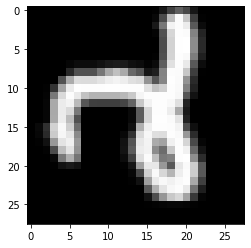

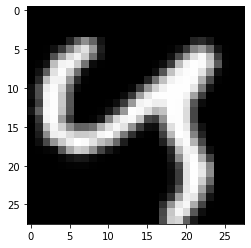

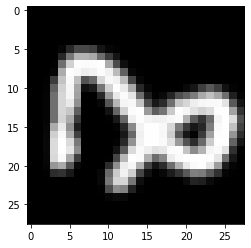

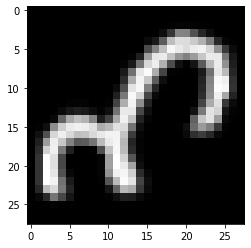

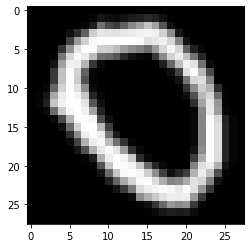

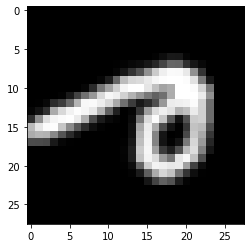

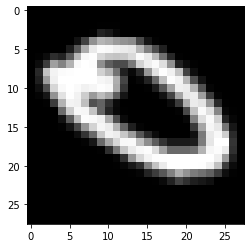

In [7]:
# 이미지를 보면 알 수 있듯이, augmentation을 데이터에 맞게 하지 않으면 말도 안 되는걸 학습하게 됩니다.
# 90도 회전시키거나 좌/우 반전을 함으로써 의미를 잃어버리는 경우도 있기 때문에 데이터에 맞는 augmentation을 해야 합니다.
for idx, (img, label) in enumerate(train_loader):
  plt.imshow(img[0, 0, ...], cmap = 'gray')
  plt.show()
  if idx > 5:
    break

## 3. Model & Optimizer

### 1) CNN Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding = 1),    # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding = 1),   # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # 14 x 14
            nn.Conv2d(32, 64, 3, padding = 1),   # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                   # 7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )       
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

### 2) Loss func & Optimizer

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

cuda:0


## 4. Train 

In [10]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)          

tensor(2.3055, device='cuda:0', grad_fn=<NllLossBackward>)


In [11]:
param_list = list(model.parameters())
print(param_list)

[Parameter containing:
tensor([[[[ 0.0896,  0.0880,  0.0285],
          [-0.0548,  0.1677, -0.0170],
          [ 0.2967,  0.3227,  0.0252]]],


        [[[-0.0149,  0.3033,  0.2212],
          [ 0.2386, -0.2418,  0.3040],
          [-0.2202,  0.3285, -0.2735]]],


        [[[-0.2293,  0.2014, -0.1033],
          [-0.0300,  0.1663,  0.1818],
          [-0.0591,  0.1791, -0.3245]]],


        [[[ 0.0426,  0.2789,  0.0426],
          [ 0.3281, -0.1284, -0.0695],
          [ 0.2549,  0.3263, -0.0033]]],


        [[[ 0.0530,  0.2643,  0.1203],
          [ 0.3075, -0.1263,  0.2987],
          [-0.0765, -0.0180,  0.3245]]],


        [[[-0.1650,  0.0720, -0.2074],
          [-0.3077, -0.0388, -0.2766],
          [ 0.2297,  0.1217,  0.0360]]],


        [[[-0.3219, -0.0747,  0.1466],
          [ 0.1262,  0.0089,  0.2988],
          [-0.0406, -0.1872,  0.0855]]],


        [[[ 0.2928, -0.1079,  0.3196],
          [-0.2639, -0.2514,  0.1351],
          [-0.2085, -0.3224,  0.0099]]],


        [

## 5. Test

In [12]:
correct = 0
total = 0

with torch.no_grad():
  for image, label in test_loader:
      x = image.to(device)
      y_ = label.to(device)

      output = model.forward(x)
      _, output_index = torch.max(output, 1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100 * correct / total))

Accuracy of Test Data: 10.316506385803223
